In [1]:
import pandas as pd
import numpy as np
import re
import itertools
from yaml import safe_dump
from matplotlib import pyplot as plt
import seaborn as sns
import json
from sklearn.externals.joblib import Memory

sns.set_style("whitegrid")
%matplotlib inline

In [2]:
# Configuration
ZONE = 'NZ'
INPUT_FILE = 'edns-report-2018-06-12.txt'

In [3]:
memory = Memory(cachedir='./cached-results', verbose=0)

In [4]:
some_errors = ['agrofresh.net.nz. nmho08u.rohmhaas.com: no address records found (NXDOMAIN)',
               'aheadstart.co.nz. ns3.ediy.co.nz: no address records found',
               'ahousethatperforms.co.nz. ns1.netdns.net: AAAA lookup failed',
               'airfarewatchdog.co.nz. ns1.smartertravelmedia.com: nameserver is a CNAME',
               'ceragem.co.nz. barcode.ceragem.co.kr: A nxdomain',
               'smalltown.co.nz smalltown.nz'
              ]

In [5]:
lookup_re = re.compile('((address|AAAA|A) lookup[s]? failed|no address records found|nameserver is a CNAME|A nxdomain)')

In [6]:
[lookup_re.search(l) for l in some_errors]

[<_sre.SRE_Match object; span=(40, 64), match='no address records found'>,
 <_sre.SRE_Match object; span=(34, 58), match='no address records found'>,
 <_sre.SRE_Match object; span=(42, 60), match='AAAA lookup failed'>,
 <_sre.SRE_Match object; span=(51, 72), match='nameserver is a CNAME'>,
 <_sre.SRE_Match object; span=(38, 48), match='A nxdomain'>,
 None]

In [7]:
lookup_errors = []
data = []
# The input file has a mix of lookup errors and the test results properly formatted
with open(INPUT_FILE, 'r') as f:
    for l in f.readlines():
        if lookup_re.search(l):
            lookup_errors.append(l.strip("\n"))
        else:
            p = l.strip("\n").lower().split(' ')
            try:
                entry = {'domain': p[0], 'address': p[1], 'server': p[2]}
                for i in range(3, len(p)):
                    l, e = p[i].split('=')
                    entry[l] = e
                data.append(entry)
            except ValueError:
                print("Line with bad format? %s" % l)
            except IndexError:
                # print("Not enough fields in %s" % l)
                lookup_errors.append(l.strip("\n"))


In [8]:
# Save the lookup errors directly into JSON
with open('%s-lookup-errors.json' % ZONE, 'w') as f:
    json.dump(lookup_errors, f)

In [9]:
d = pd.DataFrame(data)

In [10]:
d.head(5)

,address,dns,do,domain,edns,edns1,edns1opt,edns@512,ednsflags,ednsopt,ednstcp,optlist,server,signed
0,@210.55.30.66,ok,ok,0.co.nz.,ok,ok,ok,ok,ok,ok,ok,ok,(ns1.1stdomains.net.nz.):,ok
1,@210.55.30.66,ok,ok,0.net.nz.,ok,ok,ok,ok,ok,ok,ok,ok,(ns1.1stdomains.net.nz.):,ok
2,@175.41.131.225,ok,ok,0.co.nz.,ok,"noerror,badversion,soa","noerror,badversion,soa",ok,ok,ok,ok,"ok,nsid",(ns2.1stdomains.net.nz.):,ok
3,@175.41.131.225,ok,ok,0.net.nz.,ok,"noerror,badversion,soa","noerror,badversion,soa",ok,ok,ok,ok,"ok,nsid",(ns2.1stdomains.net.nz.):,ok
4,@210.55.30.66,ok,ok,001.co.nz.,ok,ok,ok,ok,ok,ok,ok,ok,(ns1.1stdomains.net.nz.):,ok


In [11]:
le_split = re.compile('(([a-z0-9\-\.]+) ([a-z0-9\-\.]+): (.*)|([a-z0-9\-\.]+) ([a-z0-9\-\.]+))$', re.IGNORECASE)
def split_lookup_error(e):
    m = le_split.match(e)
    if m is None:
        return None
    elif m.group(2) is None:
        return {'domain': m.group(5), 'server': m.group(6), 'error': None}
    else:
        return {'domain': m.group(2), 'server': m.group(3), 'error': m.group(4)}

In [12]:
# [split_lookup_error(e) for e in some_errors]

In [13]:
# [e for e in lookup_errors if split_lookup_error(e) is None]
# le_df = pd.DataFrame([split_lookup_error(e) for e in lookup_errors])

In [14]:
# le_df.head(5)

le_s = pd.DataFrame(le_df['error'].value_counts())
le_s['Zone'] = ZONE
le_s.to_json('%s-lookup-error-summary.json' % ZONE)

le_s2 = le_df[['error', 'domain']].groupby(['error']).count().reset_index()
le_s2['Zone'] = ZONE
le_s2.to_json('%s-lookup-errors-per-domain.json' % ZONE)

le_df['domain'].nunique()

len(set(d['server'].unique()).union(set(le_df['server'].unique())))

# Create a high level summary with number of unique servers, addresses and domains, to normalize future results and aggregations
with open('%s-high-level-counts.json' % ZONE, 'w') as f:
    json.dump({'Zone': ZONE,
              'unique_dom': len(set(d['domain'].unique()).union(set(le_df['domain'].unique()))),
              'unique_server': len(set(d['server'].unique()).union(set(le_df['server'].unique()))),
              'unique_address': d['address'].nunique()},
             f)

In [15]:
n_dom = d['domain'].nunique()
n_addr = d['address'].nunique()
n_server = d['server'].nunique()

In [16]:
def explode_test(r, **kwargs):
    # This is a dataframe row, it should have address, domain, server and one extra field to split
    f = [a for a in r.keys() if a not in ['address', 'domain', 'server']][0]
    return [dict(list(r.items()) + [(f, v)]) for v in r[f].split(',')]

In [17]:
@memory.cache
def summary_df(data=None, field=None):
    return pd.DataFrame([a for a in itertools.chain.from_iterable(data[['address', 'server', 'domain', field]].apply(explode_test, axis=1))])

### Section 1: General DNS statistics

In [18]:
# Summary of errors for basic DNS test
s_dns = summary_df(data=d, field='dns')

In [19]:
s1 = s_dns.groupby(['dns']).count().reset_index()
s1['perc'] = 100* (s1['domain'] / s1['domain'].sum())
s1['error_type'] = s1.apply(lambda r: 'Other' if r['perc'] < 0.1 else r['dns'], axis=1)
s1b = s1[['error_type', 'perc', 'domain']].groupby(['error_type']).sum().reset_index().sort_values(by='perc', ascending=False)
s1b['test'] = 'dns'
s1b

,error_type,perc,domain,test
3,ok,88.554536,2113269,dns
6,timeout,4.382577,104586,dns
4,refused,4.283307,102217,dns
2,nosoa,1.046512,24974,dns
1,noaa,0.985164,23510,dns
5,servfail,0.584645,13952,dns
0,Other,0.163258,3896,dns


In [20]:
s1b.to_json('%s-domain-test-results.json' % ZONE)

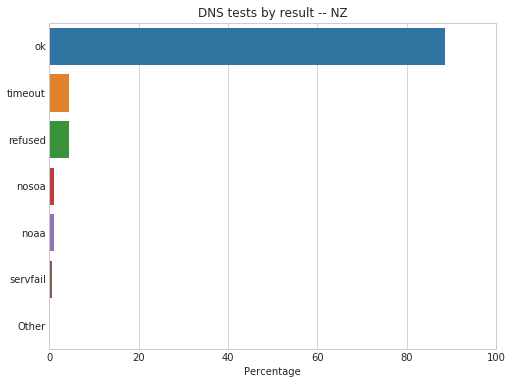

In [21]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data=s1b, x='perc', y='error_type')
ax.set(xlim=[0, 100], title='DNS tests by result -- %s' % ZONE, ylabel='', xlabel='Percentage')
plt.savefig('%s-basic-DNS-test.png' % ZONE)

In [22]:
s1.head(2)

,dns,address,domain,server,perc,error_type
0,cd,1,1,1,0.000042,Other
1,connection-refused,120,120,120,0.005028,Other


In [23]:
s_dns.head(5)

,address,dns,domain,server
0,@210.55.30.66,ok,0.co.nz.,(ns1.1stdomains.net.nz.):
1,@210.55.30.66,ok,0.net.nz.,(ns1.1stdomains.net.nz.):
2,@175.41.131.225,ok,0.co.nz.,(ns2.1stdomains.net.nz.):
3,@175.41.131.225,ok,0.net.nz.,(ns2.1stdomains.net.nz.):
4,@210.55.30.66,ok,001.co.nz.,(ns1.1stdomains.net.nz.):


In [24]:
t_server_dns = s_dns[['dns', 'server', 'domain']].groupby(['server', 'dns']).count().reset_index()
# .pivot_table(index='server', columns='dns', values='domain', fill_value=0)

In [25]:
t_server_dns['frac'] = t_server_dns['domain'] / t_server_dns.groupby('server')['domain'].transform('sum')

In [26]:
t_server_dns.head(2)

,server,dns,domain,frac
0,(0001-ns-prod-ndc.ecnrtl.com.):,ok,1,1.0
1,(0002-ns-prod-ndc.ecnrtl.com.):,ok,1,1.0


In [27]:
frac_sum = t_server_dns['frac'].sum()

In [28]:
s_server_dns = (100 * (t_server_dns[['dns', 'frac']].groupby(['dns']).sum() / frac_sum)).reset_index().sort_values(by='frac', ascending=False)

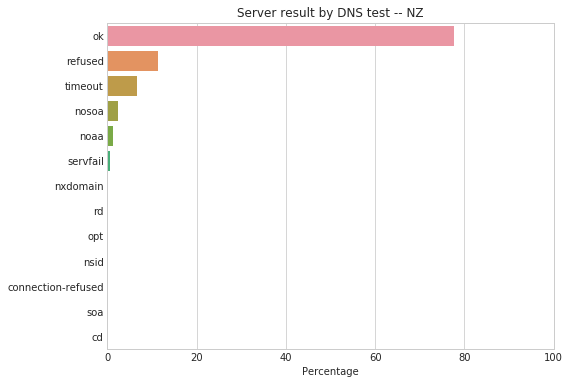

In [29]:
# Plot fraction of servers affected by each error at the DNS level
plt.figure(figsize=(8,6))
ax = sns.barplot(data=s_server_dns, x='frac', y='dns')
ax.set(xlim=[0, 100], title='Server result by DNS test -- %s' % ZONE, ylabel='', xlabel='Percentage')
plt.savefig('%s-basic-DNS-test-per-server.png' % ZONE)
s_server_dns.to_json('%s-basic-DNS-test-per-server.json' % ZONE)

### To analyze the tests properly, we need to describe them based on their dependencies. For example, if the dns test fails, the edns test is expected to fail.

![title](EDNS test decision tree.png)

In [30]:
@memory.cache
def multiple_field_summary(data=None, fields=[]):
    slist = []
    for c in fields:
        if c in ['address', 'server', 'domain']:
            continue
        if c in ['dns'] and 'dns' not in fields:
            continue
        # temporary dataframe with the specific output
        tmp_s = summary_df(data=data, field=c)
        print("Column = %s" % c)
        sg = tmp_s.groupby([c]).count().reset_index()
        sg['perc'] = 100* (sg['domain'] / sg['domain'].sum())
        sg['error_type'] = sg.apply(lambda r: 'Other' if r['perc'] < 0.1 else r[c], axis=1)
        sg2 = sg[['error_type', 'perc', 'domain']].groupby(['error_type']).sum().reset_index().sort_values(by='perc', ascending=False)
        sg2['test'] = c
        slist.append(sg2)
    
    return pd.concat(slist)

In [31]:
def plot_comparison(data=None, title=None, file_prefix=None, zone=None):
    sns.set(style='whitegrid', font_scale=1.6)
    plt.figure(figsize=(16,9))
    ax = sns.barplot(data=data, x='perc', y='error_type', hue='test', ci=None)
    ax.set(xlim=[0, 100], title=title % zone, ylabel='', xlabel='Percentage')
    plt.savefig((file_prefix % zone) + ".png")
    data['zone'] = zone
    data.to_json((file_prefix % zone) + ".json", orient='records')

### Compare DNS results against plain EDNS results

In [32]:
s_dns_edns = multiple_field_summary(data=d[d['dns']=='ok'], fields=['dns', 'edns'])

In [33]:
s_dns_edns

,error_type,perc,domain,test
0,ok,100.000000,2113269,dns
6,ok,89.990816,1932308,edns
3,noopt,7.055329,151494,edns
5,nsid,1.426677,30634,edns
1,malformed,0.753809,16186,edns
7,servfail,0.421706,9055,edns
4,nosoa,0.154851,3325,edns
2,noaa,0.154804,3324,edns
0,Other,0.042008,902,edns


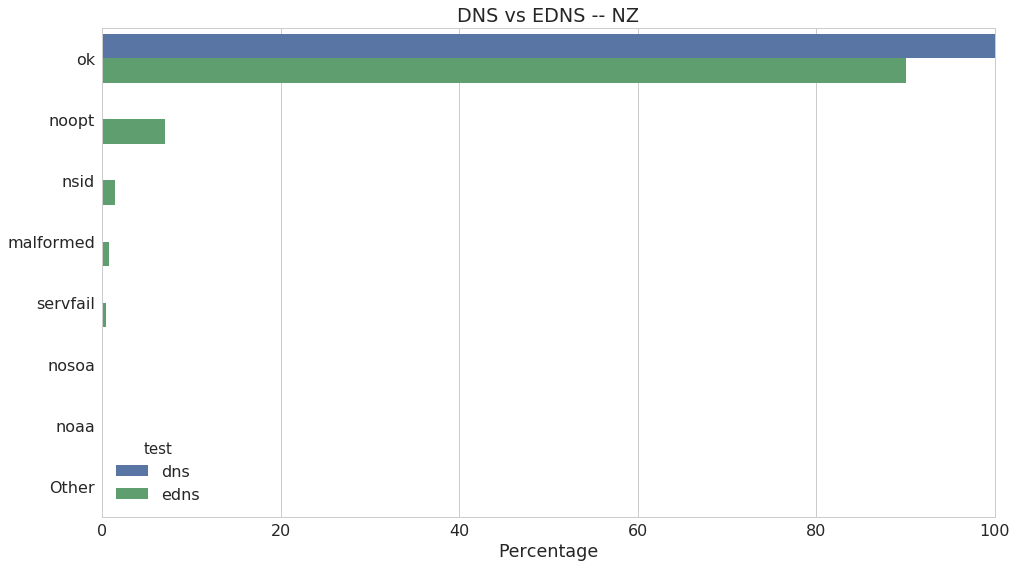

In [34]:
plot_comparison(data=s_dns_edns, title='DNS vs EDNS -- %s', file_prefix='%s-DNS-EDNS', zone=ZONE)

### Error summary by test and by server where dns=ok and where the test is 'edns' or 'edns1' 

In [35]:
s_edns_edns1 = multiple_field_summary(data=d[d['dns']=='ok'], fields=['edns', 'edns1'])

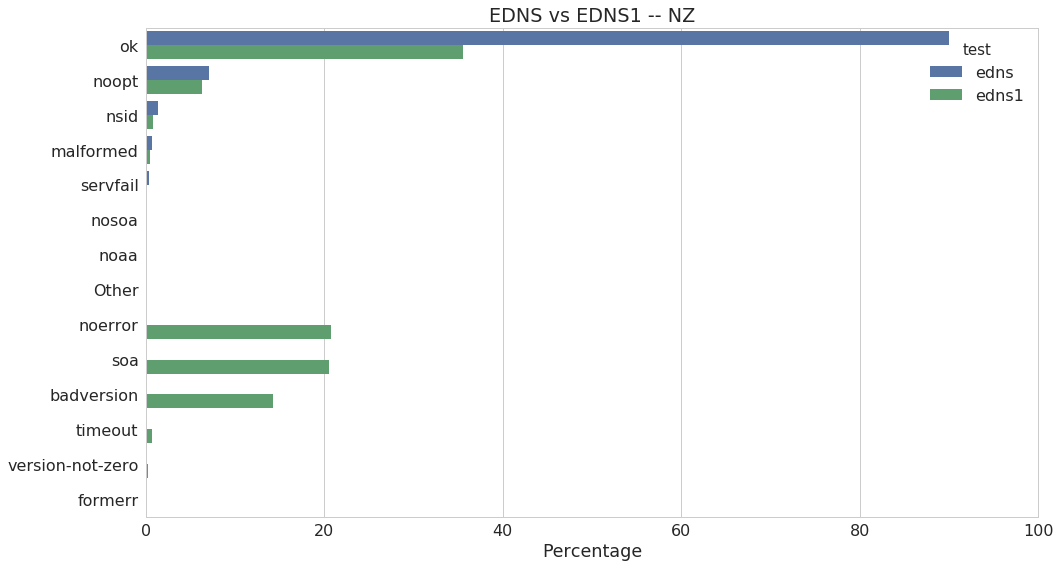

In [36]:
plot_comparison(data=s_edns_edns1, title='EDNS vs EDNS1 -- %s', file_prefix='%s-EDNS-EDNS1', zone=ZONE)

### Compare results of 'edns1' and 'edns1opt' tests when dns=ok and edns1=ok

In [37]:
s_edns1opt = multiple_field_summary(data=d[(d['dns']=='ok') & (d['edns1']=='ok')], fields=['edns1', 'edns1opt'])

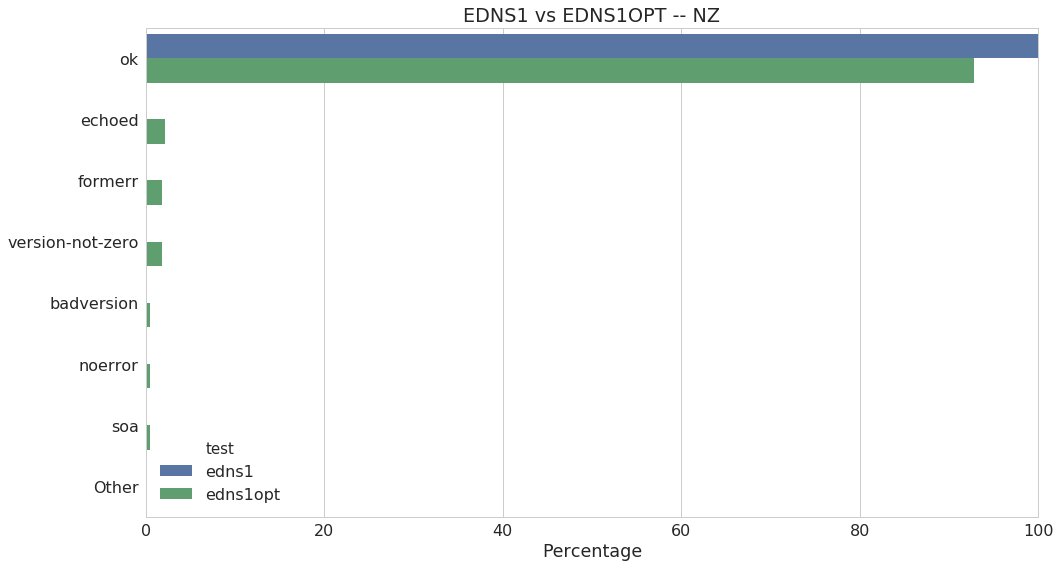

In [38]:
plot_comparison(data=s_edns1opt, title='EDNS1 vs EDNS1OPT -- %s', file_prefix='%s-EDNS1-EDNS1OPT', zone=ZONE)

### Compare results of 'do' and 'edns' 

In [39]:
s_do_edns = multiple_field_summary(data=d[(d['dns']=='ok') & (d['edns']=='ok')], fields=['edns', 'do'])

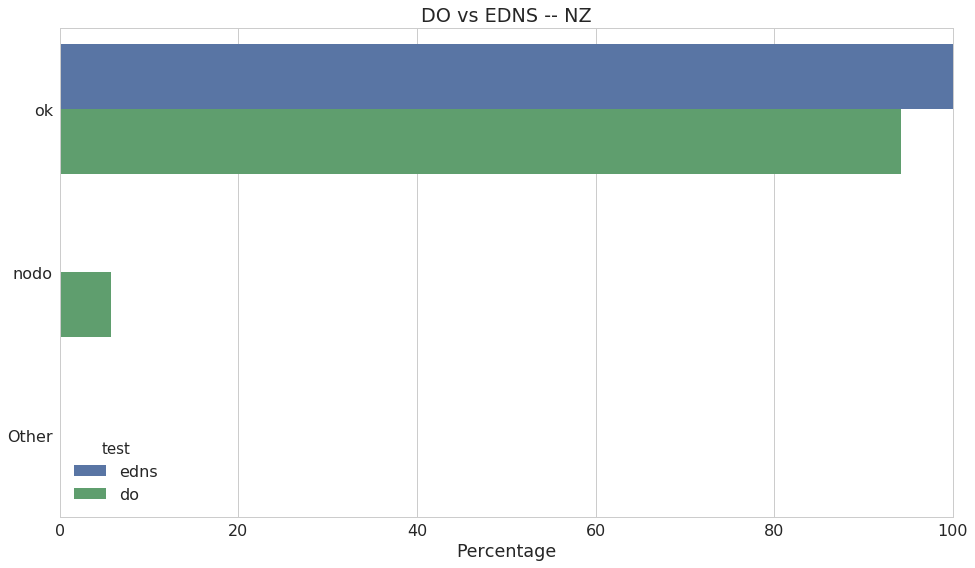

In [40]:
plot_comparison(data=s_do_edns, title='DO vs EDNS -- %s', file_prefix='%s-DO-EDNS', zone=ZONE)

### Compare results of 'do', 'ednstcp', 'edns@512' when edns=ok and do=ok

In [41]:
s_ednstcp = multiple_field_summary(data=d[(d['dns']=='ok') & (d['edns']=='ok') & (d['do']=='ok')],
                                   fields=['do', 'ednstcp', 'edns@512'])

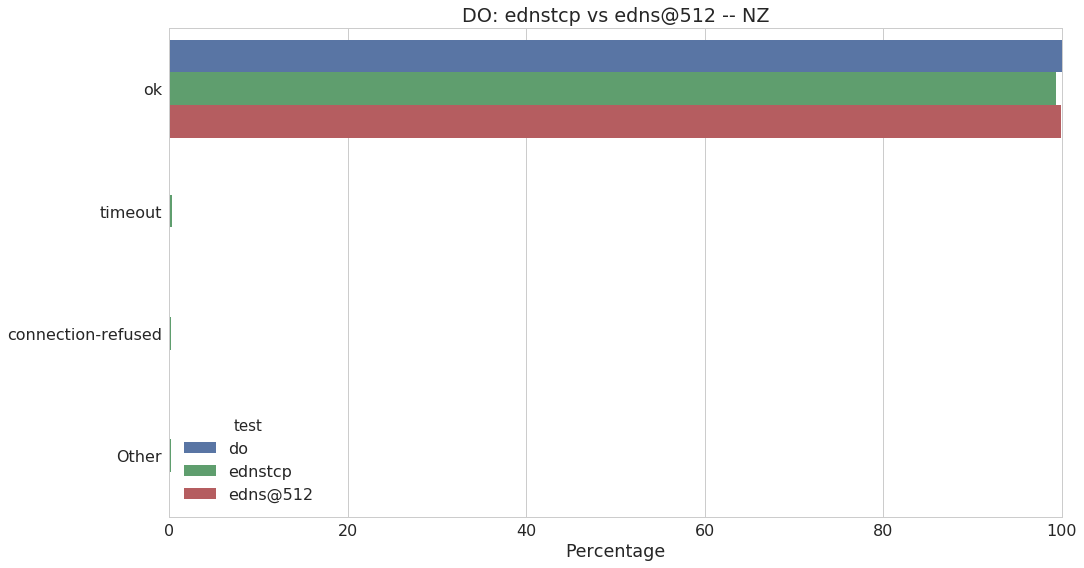

In [42]:
plot_comparison(data=s_ednstcp, title='DO: ednstcp vs edns@512 -- %s', file_prefix='%s-do-ednstcp-edns512', zone=ZONE)

### Compare 'edns' with 'ednsflags' when edns=ok

In [43]:
s_ednsflags = multiple_field_summary(data=d[(d['dns']=='ok') & (d['edns']=='ok')],
                                   fields=['edns', 'ednsflags'])

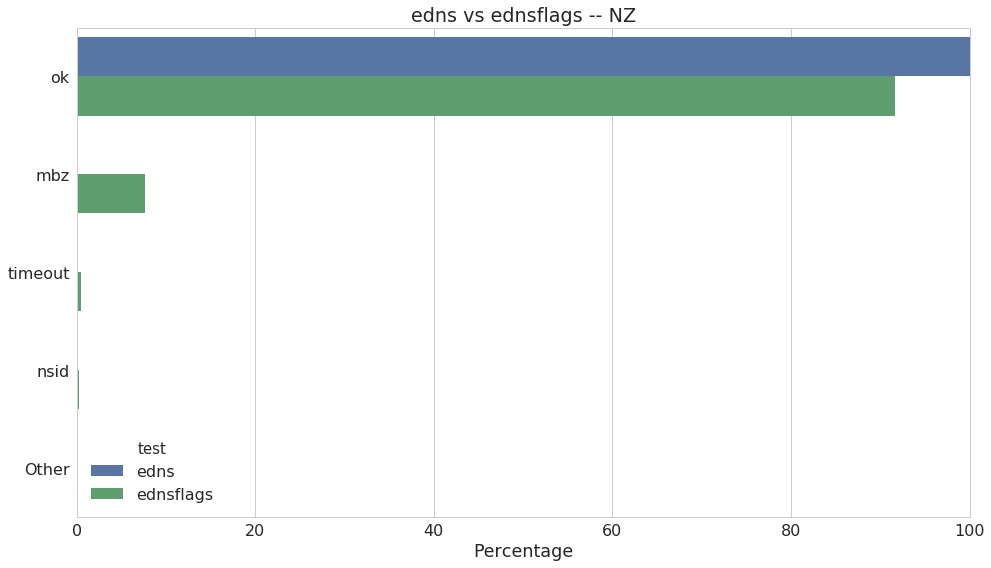

In [44]:
plot_comparison(data=s_ednsflags, title='edns vs ednsflags -- %s', file_prefix='%s-edns-ednsflags', zone=ZONE)
# plt.figure(figsize=(16,9))
# sns.barplot(data=s_ednsflags, x='perc', y='error_type', hue='test', ci=None)
# plt.savefig('nz-all-other-tests.png')

### Compare edns with optlist when edns=ok

In [45]:
s_optlist = multiple_field_summary(data=d[(d['dns']=='ok') & (d['edns']=='ok')],
                                   fields=['edns', 'optlist'])

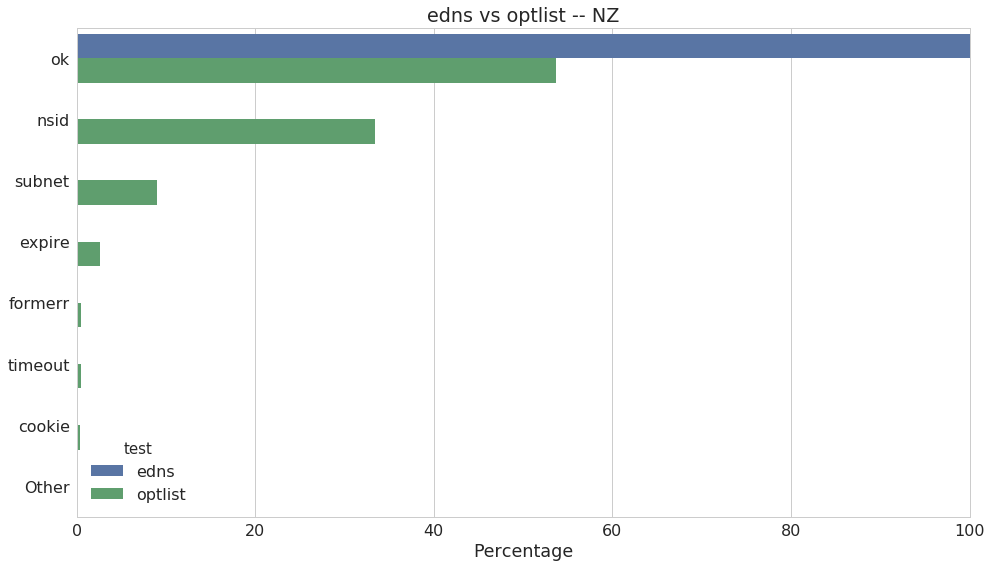

In [46]:
plot_comparison(data=s_optlist, title='edns vs optlist -- %s', file_prefix='%s-edns-optlist', zone=ZONE)

### Calculate a correctness score per server/address pair

In [47]:
d.columns

Index(['address', 'dns', 'do', 'domain', 'edns', 'edns1', 'edns1opt',
       'edns@512', 'ednsflags', 'ednsopt', 'ednstcp', 'optlist', 'server',
       'signed'],
      dtype='object')

In [48]:
import ipaddress

In [49]:
d['family'] = d['address'].apply(lambda x: "v" + str(ipaddress.ip_address(x[1:]).version))

In [50]:
sel_fields = [c for c in d.columns if c not in ['signed']]
d2 = d[sel_fields].melt(id_vars=['server', 'address', 'domain', 'family'])

In [51]:
d2[d2['value'].str.contains('ok')]['value'].unique()

array(['ok', 'ok,nsid', 'ok,nsid,subnet', 'ok,expire', 'ok,subnet',
       'refused,cookie,subnet', 'ok,nsid,expire',
       'ok,cookie+badcookie,subnet', 'ok,cookie,subnet',
       'ok,expire,cookie,subnet', 'nosoa,noaa,nsid,cookie',
       'refused,cookie', 'ok,nsid,expire,subnet',
       'ok,nsid,expire,cookie,subnet', 'ok,expire,cookie',
       'refused,nsid,cookie,subnet', 'ok,cookie', 'ok,nsid,expire,cookie',
       'ok,expire,subnet', 'nosoa,noaa,cookie,subnet',
       'ok,nsid,cookie+badcookie,subnet', 'nosoa,noaa,nsid,cookie,subnet',
       'nosoa,cookie,subnet', 'servfail,cookie,subnet', 'nosoa,cookie',
       'servfail,nsid,cookie,subnet'], dtype=object)

In [52]:
d2['score'] = d2['value'].apply(lambda x: 1.0 if x=='ok' else 0.8 if 'ok' in x else 0.0)

In [73]:
d2.head()

,server,address,domain,family,variable,value,score
0,(ns1.1stdomains.net.nz.):,@210.55.30.66,0.co.nz.,v4,dns,ok,1.0
1,(ns1.1stdomains.net.nz.):,@210.55.30.66,0.net.nz.,v4,dns,ok,1.0
2,(ns2.1stdomains.net.nz.):,@175.41.131.225,0.co.nz.,v4,dns,ok,1.0
3,(ns2.1stdomains.net.nz.):,@175.41.131.225,0.net.nz.,v4,dns,ok,1.0
4,(ns1.1stdomains.net.nz.):,@210.55.30.66,001.co.nz.,v4,dns,ok,1.0


In [53]:
BINS=10
def hist2df(data=None, col_name=None, col_value=None, col_cnt_name='server_cnt'):
    bin_range = np.arange(0.0, 1.01, 1.0/BINS)
    range_fmt = "[{0[0]:.1f}-{0[1]:.1f})"
    end_range_fmt = "[{0[0]:.1f}-{0[1]:.1f}]"
    bin_labels = [range_fmt.format(bin_range[i:i+2]) for i in range(0, len(bin_range)-2)] + [end_range_fmt.format(bin_range[-2:])]
    out, bins  = pd.cut(data, bins=bin_range, labels=bin_labels, include_lowest=True, right=True, retbins=True)
    df = pd.DataFrame(out.value_counts(sort=False))
    df.columns = [col_cnt_name]
    df['fraction'] = 100 * (df[col_cnt_name] / df[col_cnt_name].sum())
    df['fraction_cum'] = df['fraction'].cumsum()
    if col_name is not None:
        df[col_name] = col_value
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'bin'}, inplace=True)
    return df

In [54]:
server_score = d2.groupby(['server'])['score'].apply(lambda x: x.sum()/len(x)).reset_index()
server_score_hist = hist2df(server_score['score'])
server_score_hist.to_json('%s-server-score-histogram.json' % ZONE)

Text(0.5,1,'NZ -- Server score distribution')

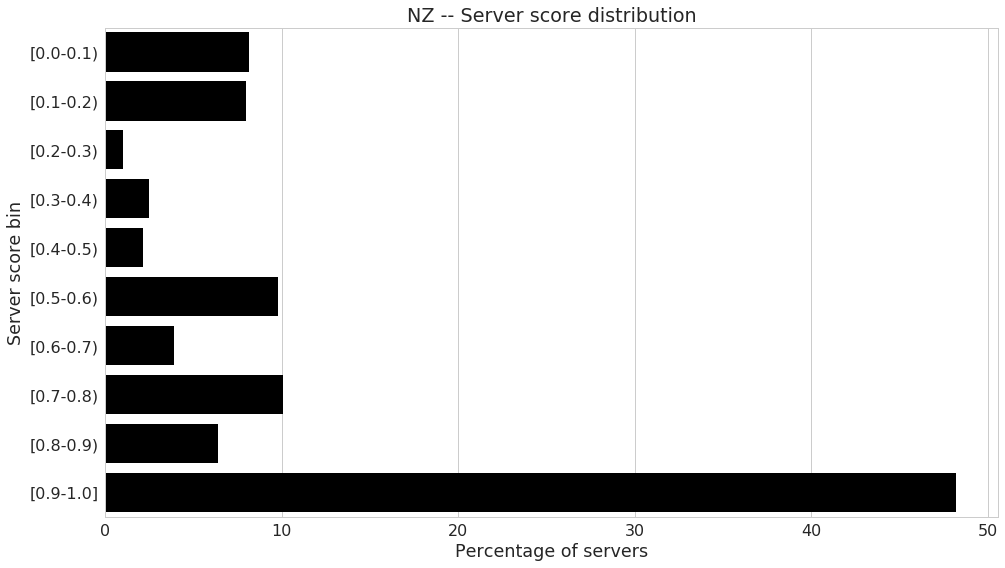

In [69]:
sns.set(style='whitegrid', font_scale=1.6)
plt.figure(figsize=(16,9))

ax = sns.barplot(data=server_score_hist, x='fraction', y='bin', color='black', saturation=0.9)
ax.set_xlabel('Percentage of servers')
ax.set_ylabel('Server score bin')
ax.set_title('%s -- Server score distribution' % ZONE)

In [76]:
server_fam_score = d2.groupby(['server', 'family'])['score'].apply(lambda x: x.sum()/len(x)).reset_index()

In [77]:
server_fam_score.head()

,server,family,score
0,(0001-ns-prod-ndc.ecnrtl.com.):,v4,1.0
1,(0002-ns-prod-ndc.ecnrtl.com.):,v4,1.0
2,(003.mpango.de.):,v4,1.0
3,(004.mpango.de.):,v4,1.0
4,(007.mpango.de.):,v4,1.0


In [84]:
server_fam_score_hist = pd.concat([hist2df(data=server_fam_score.query("family=='v4'")['score'], col_name='family', col_value='v4'),
                                   hist2df(data=server_fam_score.query("family=='v6'")['score'], col_name='family', col_value='v6')]).reset_index()
server_fam_score_hist['zone'] = ZONE
server_fam_score_hist.to_json('%s-server-score-histogram-per-address-family.json' % ZONE)

Text(0.5,1,'NZ -- nameserver score distribution per address family')

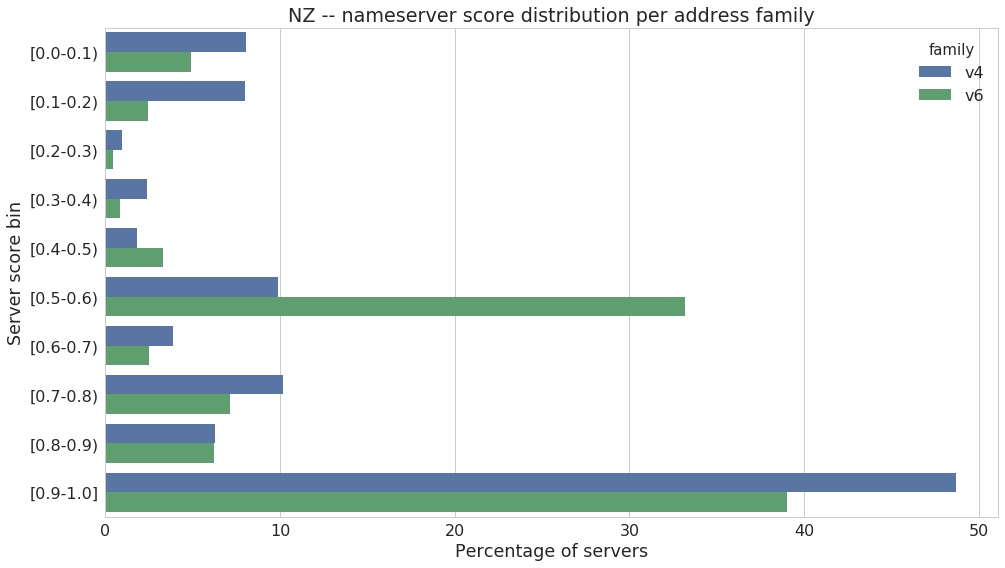

In [91]:
sns.set(style='whitegrid', font_scale=1.6)
plt.figure(figsize=(16,9))

ax = sns.barplot(data=server_fam_score_hist, y='bin', x='fraction', hue='family')
ax.set_xlabel('Percentage of servers')
ax.set_ylabel('Server score bin')
ax.set_title('%s -- nameserver score distribution per address family' % ZONE)

In [85]:
server_dual_stack_score = d2.groupby(['server', 'family'])['score'].apply(lambda x: x.sum()/len(x)).reset_index().pivot_table(index='server', columns='family', values='score').dropna().reset_index()

In [87]:
server_dual_stack_score_hist = pd.concat([hist2df(data=server_dual_stack_score['v4'], col_name='family', col_value='v4'),
                                   hist2df(data=server_dual_stack_score['v6'], col_name='family', col_value='v6')]).reset_index()
server_dual_stack_score_hist['zone'] = ZONE
server_dual_stack_score_hist.to_json('%s-dual-stack-server-score-histogram.json' % ZONE)

In [88]:
server_dual_stack_score_hist.head()

,index,bin,server_cnt,fraction,fraction_cum,family,zone
0,0,[0.0-0.1),116,1.914191,1.914191,v4,NZ
1,1,[0.1-0.2),170,2.805281,4.719472,v4,NZ
2,2,[0.2-0.3),27,0.445545,5.165017,v4,NZ
3,3,[0.3-0.4),55,0.907591,6.072607,v4,NZ
4,4,[0.4-0.5),54,0.891089,6.963696,v4,NZ


Text(0.5,1,'NZ -- dual-stack nameserver score distribution')

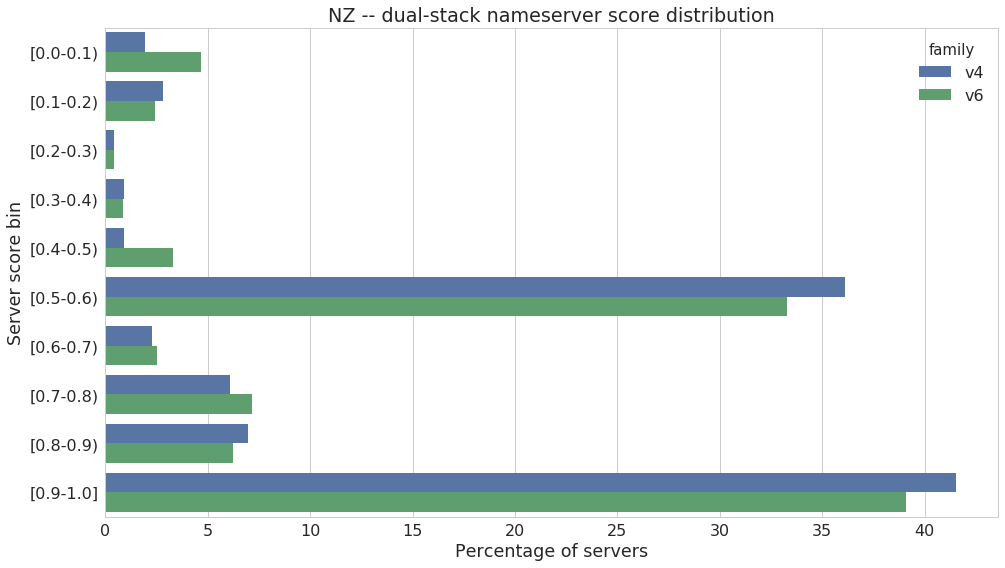

In [90]:
sns.set(style='whitegrid', font_scale=1.6)
plt.figure(figsize=(16,9))

ax = sns.barplot(data=server_dual_stack_score_hist, y='bin', x='fraction', hue='family')
ax.set_xlabel('Percentage of servers')
ax.set_ylabel('Server score bin')
ax.set_title('%s -- dual-stack nameserver score distribution' % ZONE)

In [ ]:
# Identify the servers that have both IPv4 and IPv6 for a fair comparison


In [61]:
domain_score = d2.groupby(['domain'])['score'].apply(lambda x: x.sum()/len(x)).reset_index()

In [62]:
domain_score_hist = hist2df(data=domain_score['score'], col_cnt_name='dom_cnt').reset_index()

Text(0.5,1,'NZ -- Domain score distribution')

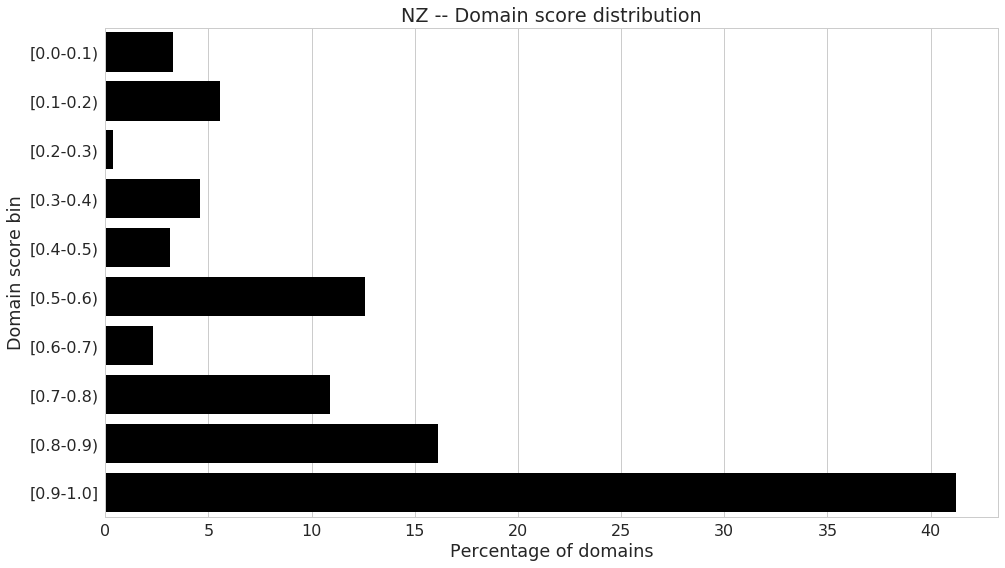

In [68]:
sns.set(style='whitegrid', font_scale=1.6)
plt.figure(figsize=(16,9))

ax = sns.barplot(data=domain_score_hist, x='fraction', y='bin', color='black', saturation=0.9)
ax.set_xlabel('Percentage of domains')
ax.set_ylabel('Domain score bin')
ax.set_title('%s -- Domain score distribution' % ZONE)


In [64]:
domain_score_hist.to_json('%s-domain-score-histogram.json' % ZONE)